# Analysis of TSP Approximation Algorithms
## Introduction to TSP
The problem is often described as a salesman who would like to visit each city no more than once and return home. The journey to each city has a certain expense; the salesman would like to find the most optimal solution. This can be represented with edge weights between the vertices. So we want to find a route where the sum of the edge weights is the lowest possible value. Given a large set of cities (nodes) this has proven to be an intractable problem- it's NP-hard. 

Before getting into it, let's consider two other common paths that may traverse a graph. The first is an Eulerian circuit which touches every node in the graph and returns to the origin. The second is a Hamiltonian cycle which similar to the Eulerian cycle in that it must touch every node and return to the origin. However the Hamiltonian cycle mandates that each node is only visited once. This is quite similar to the Traveling Salesperson Problem, a reduction can be shown to prove that TSP is NP-hard without too much massaging. Think of the Traveling Salesman Problem as finding the Hamiltonian cycle with the minimum possible weight.

It's important to note that the algorithms in question, and indeed the ones implemented below, are only approximations. Approximations appear to be the only way to solve inputs that are millions of cities large. They find solutions with approximation ratios that may be considered "good enough". Good enough of course depends on the standard one chooses to hold, but algorithms of note seem to yield a solution which is 2-3% close to optimal.[1] One of the approximations will fail terribly, this is the nearest neighbor. Christofides actually does quite well, yielding the best approximation ratio of all known algorithms in the general case. 

## Why I chose this algorithm

## Graph theory primer
This is a graph problem, being as such there are a few properties we can exploit, and some that will hinder us. We already talked about the Hamiltonian Cycle and its relationship with the Traveling Salesperson Problem, but we didn't consider the graph itself. There are two types of graphs of note. One is a complete graph and the other is not. A complete graph means that all edges in the graph can reach every other edge. Any two nodes in a graph that are not connected makes a graph incomplete, but it may still be connected. A connected graph means that, by some path, we can reach every node. This is usually verified by running DFS on the graph, an operation that has a smaller time complexity than the algorithm for finding a TSP solution. In fact, the input graph is verified at the beginning to confirm it's connectivity.

Let's consider the graph's nodes (vertices). For this problem we'll need to keep an associated attribute with the node to determine if it has already been visited. Remember, we're not allowed to visit the same city twice. We'll also want to note the origin, or the location that we've started at because the result should be a cycle. This means that our salesperson returns to the place from which they began. Nodes are pretty straight forward, as long as they're connected by edges we should be alright.

Now for the edges, which have slightly more interesting properties. This is an undirected graph, which generally makes traversal more simple. This means that an edge can be taken in either direction. Edges also have a second property, which is their weight. The weight of an edge is an attribute that states how costly it will be for our salesperson to travel from the current node along that edge to the next node. The graphs used here are not plotted on a Cartesian coordinate system. This means that the distance between a pair of nodes has nothing to do with the weight of the edge. As an aside, the graphs plotted below have nodes placed in a screw formation to make them readable. Graphviz, another plotting tool, makes graphs where the nodes do not overlap and the edges can be traced. Back to these edges; another constraint on the weights are that they cannot be negative. This is useful for the functions, and makes sense in reality. A salesperson cannot go a negative distance, as it really has no meaning. Finally, let's acknowledge the variation in weights. I've set the upper bound to be about twice as much as the number of nodes. However, there may still be two edges with the same value incident to a node. Which edges will be taken depends on the alogrithm in question, but it should make no difference in analysis.

To elaborate slightly more on the cycles that are discovered, first remember that we're looking for a best approximation. While it may make sense to try an algorithm more than once from various origins, it seems fitting that we'll just accept the bad answer that we're provided on the first completion. This saves us from the rabbit hole of searching for an optimal solution using an algorithm that we know may not provide one. So once a valid Hamiltonian cycle is found, we consider that the result of the algorithm. With a completed graph this should always execute on the first try. However, if the graph is not complete we may exhaust other origins in an attempt to find the cycle. Importantly, an algorithm may not find a path for our salesperson even though one exists if the input graph is not connected.

Lastly, it must be explicitly addressed that we're looking for an approximation algorithm. These are not guaranteed to yield an optimal solution, in fact they likely won't. There is need for a metric to compare these algorithms and the optimal solution is the clear choice. For large inputs a known optimal solution can be pitted against the algorithms developed here. The way to measure how well one algorithm did in comparison to the optimal path is to take the ratio of the two. This is known as the approximation ratio. 

## Nearest neighbor
This algorithm is a great example of what not to do. For one, it very easily will not find a solution even when one is evident. Nearest neighbor is a greedy algorithm which means it will take whatever choice looks best from its current position. When it arrives at a node it evaluates each of the neighboring nodes and determines which have yet to be accessed. Then it takes the lowest weight of those possibilities. It's horribly simple, but will always find a solution on a completed graph. The approximation ratio from various sources state that it gets to within 15-25% of the optimal solution.

You may notice that this is a silly procedure as it could funnel its way into a trap from which it cannot return. This tends to happen most with triangle shapes where the point furthest from the origin has the heaviest edge of the three that comprise the triangle. This is because it will navigate the base of the triangle, then greedily turn away from the origin and towards the point of the triangle. From here it cannot return as it's already touched the two base nodes. Surely there are other mistakes that this algorithm can make, but this one happens to be easiest to imagine.

Without a map, this may be the way someone would travel in reality. If you think about it, we're just taking the path of least resistance. If what's immediately in front of us proves to be a challenge (high weight), we'll look for all other routes before taking it. Clearly this is suboptimal as there are many cases in life where the challenging path up front results in a better overall result. Another issue with this algorithm is we may end up taking simple paths all the way till the end, but be forced to take an expensive path to the origin. Obviously this happens because we've removed all other nodes from the set of optional moves, but without a mechanism that provides foresight it's an unavoidable expense.

Here's some annotated [mathy stuff](https://www.youtube.com/watch?v=zM5MW5NKZJg)
```
1) The distance between any two nodes is greater than or equal to zero 
     d(x,y) >= 0
2) The graph is undirected 
     d(x,y) = d(y,x) 
3) The triangle inequality exists: If a single edge reachs a point that two or more edges can reach together, the single edge is shorter than the sum of the other edges. 
     d(x,y) + d(y,z) >= d(x,z)
```

### Psuedocode
Just to be clear, the structure of the psuedocode came from Wikipedia and has been elaborated on. In general, it's standard to consider node `u` as the node we're currently at and node `v` as the node to which we may travel. This is evident based on parameters in the `networkx` python3 library used below. Also, the original psuedocode must have been written for a complete graph. The modifications made will rotate the origin through all possible nodes until a Hamiltonian cycle is found. Again, we have no way of guaranteeing a better path, so we halt on the first encountered.
```
Psuedocode
 0) sum = the total cost of traveling the paths.
 1) Initialize all vertices as unvisited and add them the list possible origins.
 2) Select a vertex from the list of possible origins, set it as the current vertex u. Mark u as visited.
 3) Find out the shortest edge e connecting the current vertex u and an unvisited vertex v.
 4) Set v as the current vertex u. Mark v as visited. Add e to sum.
 5) If u can access another vertex v that is not the origin go to step 3.
 6) Else If u can access the origin via e add e to sum and return sum
 6) Else remove the origin from the list of possible origins.  
 7)   If possible origins is empty return false, no path found.
 8)   Else go to step 2.
```
### Complexity
Of course, when analyzing an algorithm we only care about worst case complexity (big O). Here, the worst case possibility is we find our path when the last possible origin is used from the list of possible origins. This means that we have looked at each node once for every possible origin. Since all nodes are candidates for an origin, we have a `O(n^2)` algorithm. Let's put this into perspective to see how bad it is. Depth first search, an algorithm which also traverses all of the nodes in a graph, has a runtime of `O(|V|+|E|)`. You could say that it's a linear algorithm with space complexity greater than constant because it keeps track of the route taken. Well considering it's not tasked with finding a Hamiltonian circuit, nearest neighbor doesn't actually seem that bad! It's polynomial after all, and it's space complexity is just a list of all the nodes in the graph, `O(n)`. A very tolerable running time indeed. But we must not forget its numerous pitfalls. For one, it may not find a solution even though it exists. 

It's important to note that I did not implement reptitive nearest neighbor. Reptitive nearest neighbor would run the algorithm above on all inputs and store every possible route until the origin list has been exhausted. From there it would compare the different solutions and find the shortest of the paths in that data structure. In my opinion, this blows up the space complexity and would not be practical. In theory, this would have been easy to accomplish by storing the path with all of the path data in a lookup table. Now our space complexity would be `O(n^2)` since there may be a copy of all paths for each possible origin. The runtime complexity would still be `O(n^2)`. Even though it's often considered that storage is cheap, for a large graph the first Hamiltonian cycle may also prove to be a challenge. Since the results are already expected to be suboptimal, with a particular input repetitive nearest neighbor would not be necessary. Briefly, there are some interesting guarantees when iterating through every possible origin. For instance, it will always produce a tour better than at least `n/2-1`. other possible tours. Sometimes it finds a tour better than `n-2` other tours when `n >= 4`. (TODO CITE)

### Results
For just a quick second, I want to talk about the small graph. It doesn't lend any use to comparing the algorithm against an optimal solution, but it does develop a human intution. We're quite capable of seeing a decent cycle, and we can also follow a graph by hand to find where one route underperforms and another would succeed. This is because we have a top down picture and foresight, the greedy algorithm does not.


# TODO results from large run
differences between running on a complete graph vs a sparse graph.
    complete: there will always be a solution
    sparse: seems to find its way to positions from which it cannot return. Greedily

In [44]:
# This cell must be run before the other cells.
import networkx as nx
import random as rng
from networkx.drawing.nx_pydot import write_dot

class StopExecution(Exception):
    def _render_traceback_(self):
        pass

Number of nodes in small graph: 6


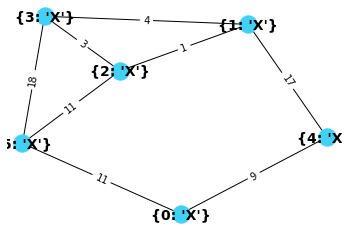

In [730]:
###############################
#     SMALL VISUAL GRAPH      #
###############################
sm_num_of_nodes = 6 # rng.randrange(5,10)
max_edge_weight = 20
prob_of_edge_creation = 0.5

print("Number of nodes in small graph: {}".format(sm_num_of_nodes))
sm_graph = nx.fast_gnp_random_graph(sm_num_of_nodes, prob_of_edge_creation, None, False)

# only works on connected graphs.
while not nx.is_connected(sm_graph):
    sm_graph = nx.fast_gnp_random_graph(sm_num_of_nodes, prob_of_edge_creation, None, False)
    
output_graph = nx.create_empty_copy(sm_graph,with_data=False)

# for each node in the small graph, initialize it to unvisited
fresh_node_labels = [{'visited': 'X', 'origin': False}] # if `fresh_node_labels` is not a dictionary then it's applied to all nodes
nx.set_node_attributes(sm_graph, fresh_node_labels, 'node-label')

# for each node in the small graph, assign a random weight
for (u, v) in sm_graph.edges():
    sm_graph.edges[u,v]['weight'] = rng.randint(1, max_edge_weight)
    
# add edges to the small graph that is printable
pos = nx.nx_agraph.graphviz_layout(sm_graph)
edge_labels = nx.get_edge_attributes(sm_graph,'weight')
edges_label = nx.draw_networkx_edge_labels(sm_graph, pos, edge_labels=edge_labels)

# need to remove the origin attribute being passed to `draw` to keep it clean
node_labels = nx.get_node_attributes(sm_graph, 'node-label')
print_node_labels = dict()
for n in node_labels.items():
    print_node_labels[n[0]] = {n[0] : n[1][0]['visited']}

# Draw the graph below
nx.draw(sm_graph, pos=pos, labels=print_node_labels, node_color='#42d1f5', font_size=14, font_weight='bold')

Two things about these chunks of code above and below. The one below is dependent on the one above, so the one above must be run first. Also, if the graph is not complete (i.e. `prob_of_edge_creation != 1.0`) then you may generate graphs which obviously don't have a Hamiltonian cycle. 

Best route nearest neighbor could find: 59


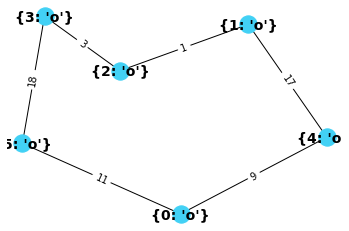

In [731]:
###############################
#     SMALL VISUAL GRAPH      #
###############################
verbose = True
output_graph = nx.create_empty_copy(sm_graph,with_data=False)

# At the beginning, all nodes are unvisited and marked with 'X'
# origin is the current_node to start
origin = rng.randrange(0, sm_num_of_nodes)
current_node = origin

# A list of attempted origins in case the origin doesn't work out.
attempted_origins = list(range(sm_num_of_nodes))

next_node = None
total_path_weight = 0
is_ham_circuit = False

# set origin to true by accessing that particular node and updating it's attribute by sending in a new dict
nx.set_node_attributes(sm_graph, {current_node: {'node-label': [{'visited': 'o', 'origin': True}]}})

while True:
    
    # flag to show if further travel is possible
    neighbor_exists = False
    
    # reset the highest possible weight
    lowest_weight_edge = max_edge_weight + 1

    # all nodes that share an edge incident to current_node
    neighbors = [n for n in sm_graph.neighbors(current_node)]
    
    for node in neighbors:
        
        # has the neighbor node been visited
        not_visited = sm_graph.nodes[node]['node-label'][0]['visited'] != 'o'
            
        # weight of the edge to the neighbor node
        edge_weight_to_neighbor = sm_graph.get_edge_data(current_node, node)['weight']
        
        # is neighbor node the origin
        is_origin = sm_graph.nodes[node]['node-label'][0]['origin']
        
        # if the node hasn't been visited, the edge between this and that is current minimum, it ain't the origin
        if not_visited and edge_weight_to_neighbor < lowest_weight_edge and not is_origin:        
            
            # this is now the edge lowest weight edge leaving `u`
            lowest_weight_edge = edge_weight_to_neighbor
            next_node = node
            
            # need to know if we should try and return to origin
            neighbor_exists = True 
            
    # attempt to get back to the origin, need to iterate once more. we couldn't have taken this edge before
    if not neighbor_exists:
        for node in neighbors:
            is_origin = sm_graph.nodes[node]['node-label'][0]['origin']
            if is_origin:
                # simply add that edge weight and return
                next_edge_weight = sm_graph.get_edge_data(current_node, node)['weight']
                output_graph.add_edge(current_node, node, weight=next_edge_weight)
                total_path_weight += next_edge_weight            
                is_ham_circuit = True
                    
        if is_ham_circuit:
            break
        else:
            
            # try different origins till exhaustion
            attempted_origins.remove(origin)

            # update the origin
            if not attempted_origins:
                print("Unable to find a Hamiltonian circuit for our salesperson.")
                raise StopExecution
            
            # get a new origin
            origin = attempted_origins[0] 
            current_node = origin

            # refresh the 'visited' attribute of the previously visited nodes, assign origin
            node_labels = [{'visited': 'X', 'origin': False}] 
            nx.set_node_attributes(sm_graph, node_labels, 'node-label')
            nx.set_node_attributes(sm_graph, {current_node: {'node-label': [{'visited': 'o', 'origin': True}]}})

            # clone the old graph after it's been reset, no edge data.
            output_graph = nx.create_empty_copy(sm_graph,with_data=False)

            # reset all of the flags
            total_path_weight = 0
            neighbor_exists = False
            next_node = None
            continue
    
    # then a neighbor to travel to must exist. update the graph
    next_edge_weight = sm_graph.get_edge_data(current_node, next_node)['weight']
    output_graph.add_edge(current_node, next_node, weight=next_edge_weight)
    
    # increase the new total weight and update node position
    total_path_weight += next_edge_weight
    current_node = next_node 
    
    # update the visited most recent node's attribute    
    nx.set_node_attributes(sm_graph, {current_node: {'node-label': [{'visited': 'o', 'origin': False}]}})

    
print("Best route nearest neighbor could find: " + str(total_path_weight))
# drawing stuff
node_labels = nx.get_node_attributes(sm_graph, 'node-label')
print_node_labels = dict()
for n in node_labels.items():
    print_node_labels[n[0]] = {n[0] : n[1][0]['visited']}
pos = nx.nx_agraph.graphviz_layout(sm_graph)
edge_labels = nx.get_edge_attributes(output_graph,'weight')
edges_label = nx.draw_networkx_edge_labels(output_graph, pos, edge_labels=edge_labels)
nx.draw(output_graph, pos=pos, labels=print_node_labels, node_color='#42d1f5', font_size=14, font_weight='bold')

An interesting thing to note about nearest neighbor is we'd technically always choose the lowest edge to ALL points in the graph. However, no node could exist two edges away and have a lesser weight then if we'd go through the intermediate note. With the assumption that there are no negative weights, that is.

THE ALGORITHM CAN FAIL! When that happens we simply choose another node in the set. that is why there is n^2 running time, we may need to try all possible paths.

DO THE OTHER ALGORITHMS DEPEND ON TRIANGLE INEQUALITY



Number of nodes in large graph: 6


TypeError: string indices must be integers

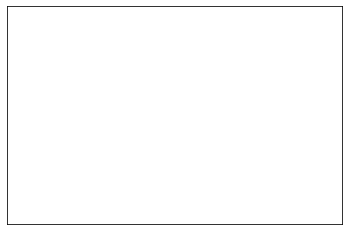

In [547]:
###############################
#     LARGE VISUAL GRAPH      #
###############################
lg_num_of_nodes = rng.randrange(5, 8)
max_edge_weight = 20
prob_of_edge_creation = 1.0

print("Number of nodes in large graph: {}".format(lg_num_of_nodes))

lg_graph = nx.fast_gnp_random_graph(lg_num_of_nodes, prob_of_edge_creation, None, False)
output_graph = nx.create_empty_copy(lg_graph,with_data=False)

# for each node in the large graph, initialize it to unvisited
node_labels = ['X'] 
nx.set_node_attributes(lg_graph, node_labels, 'node-label')

# for each node in the small graph, assign a random weight
for (u, v) in lg_graph.edges():
    lg_graph.edges[u,v]['weight'] = rng.randint(1, max_edge_weight)
    
    
verbose = True
output_graph = nx.create_empty_copy(sm_graph,with_data=False)

# At the beginning, all nodes are unvisited and marked with 'X'
# origin is the current_node to start
origin = rng.randrange(0, sm_num_of_nodes)
current_node = origin

# A list of attempted origins in case the origin doesn't work out.
attempted_origins = list(range(sm_num_of_nodes))

next_node = None
total_path_weight = 0
is_ham_circuit = False

# set origin to true by accessing that particular node and updating it's attribute by sending in a new dict
nx.set_node_attributes(sm_graph, {current_node: {'node-label': [{'visited': 'o', 'origin': True}]}})

while True:
    
    # flag to show if further travel is possible
    neighbor_exists = False
    
    # reset the highest possible weight
    lowest_weight_edge = max_edge_weight + 1

    # all nodes that share an edge incident to current_node
    neighbors = [n for n in sm_graph.neighbors(current_node)]
    
    for node in neighbors:
        
        # has the neighbor node been visited
        not_visited = sm_graph.nodes[node]['node-label'][0]['visited'] != 'o'
            
        # weight of the edge to the neighbor node
        edge_weight_to_neighbor = sm_graph.get_edge_data(current_node, node)['weight']
        
        # is neighbor node the origin
        is_origin = sm_graph.nodes[node]['node-label'][0]['origin']
        
        # if the node hasn't been visited, the edge between this and that is current minimum, it ain't the origin
        if not_visited and edge_weight_to_neighbor < lowest_weight_edge and not is_origin:        
            
            # this is now the edge lowest weight edge leaving `u`
            lowest_weight_edge = edge_weight_to_neighbor
            next_node = node
            
            # need to know if we should try and return to origin
            neighbor_exists = True 
            
    # attempt to get back to the origin, need to iterate once more. we couldn't have taken this edge before
    if not neighbor_exists:
        for node in neighbors:
            is_origin = sm_graph.nodes[node]['node-label'][0]['origin']
            if is_origin:
                # simply add that edge weight and return
                next_edge_weight = sm_graph.get_edge_data(current_node, node)['weight']
                output_graph.add_edge(current_node, node, weight=next_edge_weight)
                total_path_weight += next_edge_weight            
                is_ham_circuit = True
                    
        if is_ham_circuit:
            break
        else:
            
            # try different origins till exhaustion
            attempted_origins.remove(origin)

            # update the origin
            if not attempted_origins:
                print("Unable to find a Hamiltonian circuit for our salesperson.")
                raise StopExecution
            
            # get a new origin
            origin = attempted_origins[0] 
            current_node = origin

            # refresh the 'visited' attribute of the previously visited nodes, assign origin
            node_labels = [{'visited': 'X', 'origin': False}] 
            nx.set_node_attributes(sm_graph, node_labels, 'node-label')
            nx.set_node_attributes(sm_graph, {current_node: {'node-label': [{'visited': 'o', 'origin': True}]}})

            # clone the old graph after it's been reset, no edge data.
            output_graph = nx.create_empty_copy(sm_graph,with_data=False)

            # reset all of the flags
            total_path_weight = 0
            neighbor_exists = False
            next_node = None
            continue
    
    # then a neighbor to travel to must exist. update the graph
    next_edge_weight = sm_graph.get_edge_data(current_node, next_node)['weight']
    output_graph.add_edge(current_node, next_node, weight=next_edge_weight)
    
    # increase the new total weight and update node position
    total_path_weight += next_edge_weight
    current_node = next_node 
    
    # update the visited most recent node's attribute    
    nx.set_node_attributes(sm_graph, {current_node: {'node-label': [{'visited': 'o', 'origin': False}]}})

# add edges to the small graph that is printable
# pos = nx.nx_agraph.graphviz_layout(lg_graph)
# edge_labels = nx.get_edge_attributes(lg_graph,'weight')
# edges_label = nx.draw_networkx_edge_labels(lg_graph, pos, edge_labels=edge_labels)

# need to remove the origin attribute being passed to `draw` to keep it clean ? Do I need this stuff with graphviz?
# node_labels = nx.get_node_attributes(lg_graph, 'node-label')
# print_node_labels = dict()
# for n in node_labels.items():
#     print_node_labels[n[0]] = {n[0] : n[1][0]['visited']}

write_dot(lg_graph, 'file43.dot')
print("Dot file written")
! dot -Tpng file43.dot -o file43.png  # add -v for verbose output
print("Dot to png conversion complete")
! chmod 777 file43.png # wide open permissions until this is constrained
print("\nThis is a graph before finding an optimal path.")


## Really need to do Christofide's algorithm.

## Really need to compare these vs some known algorithm.

![dotimage](./file43.png)
// begin with christofides

// the third one
    // ejection chains

// comparison of the three

// results

// conclusion

document references
https://www.sciencedirect.com/science/article/pii/S0377221710006065?via%3Dihub
Rosenkrantz, D. J.; Stearns, R. E.; Lewis, P. M. (14–16 October 1974). Approximate algorithms for the traveling salesperson problem. 15th Annual Symposium on Switching and Automata Theory (swat 1974). (NN triangle inequality)

Johnson, D. S.; McGeoch, L. A. (1997). "The Traveling Salesman Problem: A Case Study in Local Optimization" (PDF). In Aarts, E. H. L.; Lenstra, J. K. (eds.). Local Search in Combinatorial Optimisation. London: John Wiley and Sons Ltd. pp. 215–310. (25% optimal)

G. Gutin, A. Yeo and A. Zverovich, Traveling salesman should not be greedy: domination analysis of greedy-type heuristics for the TSP. Discrete Applied Mathematics 117 (2002), 81–86. (at least `n/2-1`)

programming resources
https://stackoverflow.com/questions/24005221/ipython-notebook-early-exit-from-cell/48000614
https://networkx.github.io

In [174]:
d = {1: {'weight': 8}, 2: {'weight': 14}, 13: {'weight': 1}}
lowest = 15
for e,k in d.items():
    

SyntaxError: unexpected EOF while parsing (<ipython-input-174-72c738394b5c>, line 4)

In [175]:
# helper stuff

# this is how you access a particular node

# this is how you change a node's attribute
change_label = {7:'visited'}
nx.set_node_attributes(sm_graph, change_label, 'node-label')
print(sm_graph.nodes[7])

# random
1 in G     # check if node in graph

[n for n in G if n != None]  # iterate through nodes

len(G)  # number of nodes in graph

# traverse via edges
for u, v, weight in G.edges.data('weight'):
    if weight is not None:
        # Do something useful with the edges
        pass
    
G[<some-node>] # same as G.adj, this returns a dict of all the neighbor nodes

# print all of the neighbors of a node
for n in sm_graph.neighbors(7):
    print(n)
    
# or do this for list comprehension
[n for n in sm_graph.neighbors(7)]

# accessing an individual node attribute i.e. visited or unvisited
sm_graph.nodes[7]['node-label']

# part of me wants to update the node attributes like this
nx.set_node_attributes(G, {1:{'weight':-1, 'volume':4}})
G.nodes[1]['weight']
# or this
g.nodes['node1'].update(optional_attrs)  
# but what I really need to do is not have that attribute in list of edge weight/ neighbor node attributes


# getting an edge
G.edges([0, ])  # only edges incident to these nodes

{'node-label': 'visited'}
1
2
13


'visited'